In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
import warnings
import wrangle as w
from evaluate import root_mean_squared_error
import model as m
from sklearn.linear_model import LinearRegression
import explore as e
from sklearn.preprocessing import MinMaxScaler,RobustScaler,PolynomialFeatures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')

In [11]:
reload(w)
coaster_df = w.wrangle_coasters()
train,validate,test= w.tvt_split(coaster_df,stratify='track_material')
train, validate, test = w.man_groups(train,validate,test)
scaler = RobustScaler()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 2381 to 619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            664 non-null    object  
 1   track_material  664 non-null    category
 2   seating_type    664 non-null    category
 3   speed           664 non-null    float64 
 4   height          664 non-null    float64 
 5   length          664 non-null    float64 
 6   num_inversions  664 non-null    float64 
 7   manufacturer    664 non-null    object  
 8   park            664 non-null    object  
 9   status          664 non-null    object  
 10  man_group       664 non-null    int64   
dtypes: category(2), float64(4), int64(1), object(4)
memory usage: 53.9+ KB


<AxesSubplot: xlabel='length', ylabel='residual'>

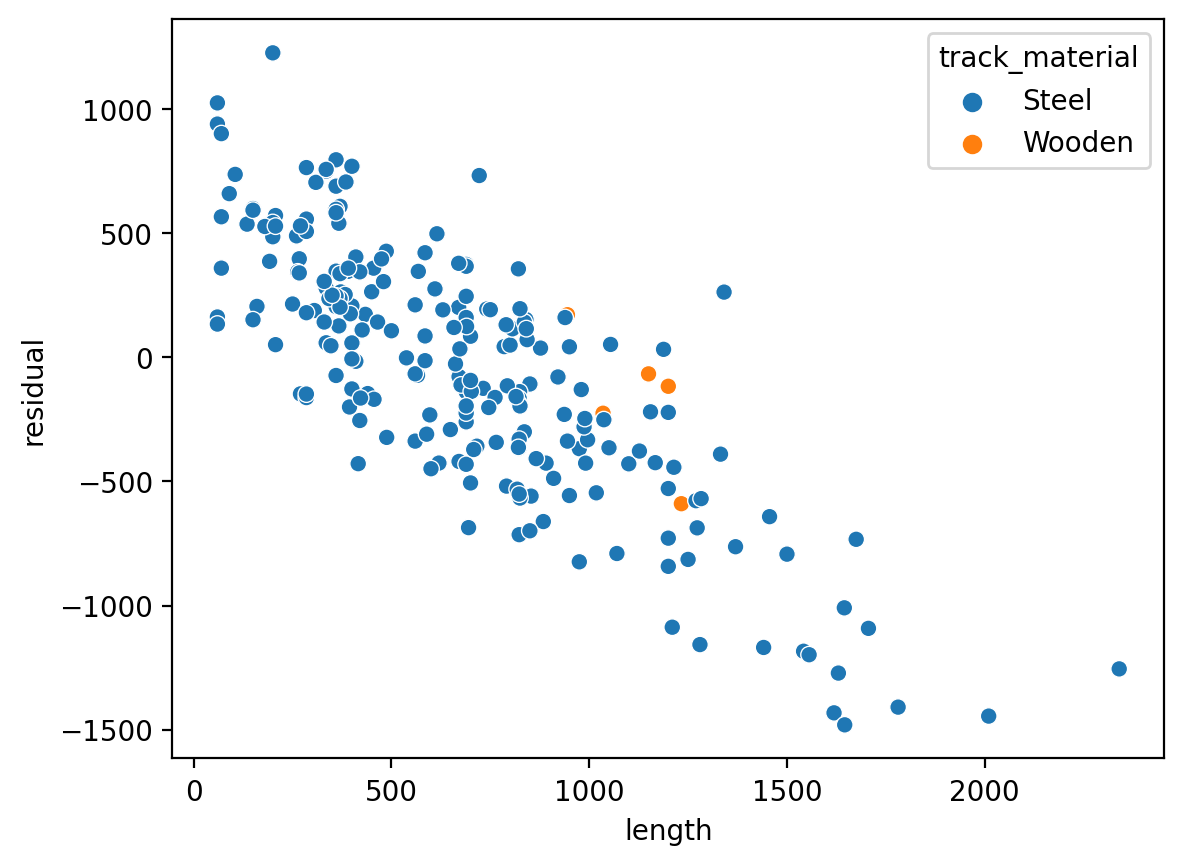

In [12]:
reload(m)
train_steel = train[train.track_material == 'Steel']
train_wood = train[train.track_material == 'Wooden']
regressor_wood = LinearRegression(normalize=True)
regressor_steel = LinearRegression(normalize=True)
train_wood['y_pred'] =m.run_regression(train_wood[['speed','man_group']],regressor_wood, train_wood.length)
train_steel['y_pred'] =m.run_regression(train_steel[['speed','man_group']],regressor_steel, train_steel.length)
train = pd.concat([train_wood,train_steel]).sort_index()
train['residual'] = train.y_pred - train.length
sns.scatterplot(data=train,x='length',y='residual',hue='track_material')

In [13]:
root_mean_squared_error(train.length,train.y_pred)

ValueError: Input contains NaN.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 2381 to 619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            664 non-null    object  
 1   track_material  664 non-null    category
 2   seating_type    664 non-null    category
 3   speed           289 non-null    float64 
 4   height          289 non-null    float64 
 5   length          664 non-null    float64 
 6   num_inversions  289 non-null    float64 
 7   manufacturer    664 non-null    object  
 8   park            664 non-null    object  
 9   status          664 non-null    object  
 10  man_group       664 non-null    int64   
dtypes: category(2), float64(4), int64(1), object(4)
memory usage: 53.9+ KB


In [14]:
reload(m)
features = ['speed','man_group']
target = 'length'
poly_scaler = PolynomialFeatures(degree=3)
scaler = RobustScaler()
trainx = train[features]
trainy = train[[target]]
validx = validate[features]
validy = validate[[target]]
scaler = RobustScaler()
strain = m.scale(trainx, scaler)
svalid = m.scale(validx,scaler)
regressor = LinearRegression()
strain = pd.DataFrame(poly_scaler.fit_transform(strain,trainy))
svalid = pd.DataFrame(poly_scaler.transform(svalid))
trainy_pred = m.run_regression(strain, regressor,trainy[target])
validy_pred = m.run_regression(svalid, regressor)
train_rmse = root_mean_squared_error(trainy[target], trainy_pred)
validate_rmse = root_mean_squared_error(validy[target], validy_pred)
ret_df = pd.DataFrame({'Train':train_rmse,'Validate':validate_rmse},index=['RMSE'])
ret_df

,Train,Validate
RMSE,246.909976,287.58582


In [15]:
from sklearn.linear_model import TweedieRegressor,LassoLars
reload(m)
tv_run = lambda r,n,p=None: m.train_and_validate(train,validate,['speed','man_group','height'],'length',r,n,p)
m.train_and_validate(train,validate,['speed','height'],'length',LassoLars(alpha=1.0),'linreg_poly',PolynomialFeatures(3))

,Train,Validate
linreg_poly,284.877126,295.583296


In [22]:
from sklearn.linear_model import TweedieRegressor
linreg = tv_run(LinearRegression(),'Linear Regression')
linreg_square = tv_run(LinearRegression(),'Squared Regression',PolynomialFeatures(2))
linreg_cube = tv_run(LinearRegression(),'Cubed Regression',PolynomialFeatures(3))
llars = tv_run(LassoLars(alpha=2.0),'LASSO+LARS')
llars_square = tv_run(LassoLars(alpha=2.0),'LASSO+LARS^2',PolynomialFeatures(2))
llars_cube = tv_run(LassoLars(alpha=2.0),'LASSO+LARS^3',PolynomialFeatures(3))
glm = tv_run(TweedieRegressor(power=1,alpha=1),'GLM')
glm_square = tv_run(TweedieRegressor(power=1,alpha=1),'GLM^2',PolynomialFeatures(2))
glm_cube = tv_run(TweedieRegressor(power=1,alpha=1),'GLM^3',PolynomialFeatures(3))
pd.concat([linreg,linreg_square,linreg_cube,llars,llars_square,llars_cube,glm,glm_square,glm_cube])

,Train,Validate
Linear Regression,264.480662,295.325323
Squared Regression,248.456778,283.605509
Cubed Regression,241.188658,285.947671
LASSO+LARS,264.480662,295.325323
LASSO+LARS^2,248.456778,283.605509
LASSO+LARS^3,241.188658,285.947671
GLM,264.480662,295.325323
GLM^2,248.456778,283.605509
GLM^3,241.188658,285.947671
